# Machine Learning Course Project
## Identifying User Stance On Social Media via Semi-Supervised Learning

### Overview

#### Midsem Pipeline - 

 - **Read Data**: Read text files to load all the words. 
 - **Clean Data**: Remove stop-words, everything lowercase, dehashify hashtags.
 - **Format Data**: Create data in a format required by each baseline method. 
 - **Baseline Approaches**: LSA, pLSA, Para2Vec, LDA Topic Modelling. The goal of these approaches is to create a "FIXED SIZE" and "HIGH LEVEL" feature representation for variable length tweets. These representations leverage our unlabelled data. 
 - **Training**: Some Supervised Learning on the learned representation using the given labels. 
 - **Evaluation**: Compare the different methods mentioned above on different datasets. 

#### Endsem Approaches - 
 - LDA2Vec - https://www.datacamp.com/community/tutorials/lda2vec-topic-model
 - Gaussian LDA - https://rajarshd.github.io/papers/acl2015.pdf
 - Word Embeddings Informed Topic Models - http://proceedings.mlr.press/v77/zhao17a/zhao17a.pdf
 
#### Reference
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Constants

In [1]:
PATH_LABELLED_DATA_TRUMP = "../semeval2016-task6-domaincorpus/data-all-annotations/testdata-taskB-all-annotations.txt"
PATH_UNLABELLED_DATA_TRUMP = "./../semeval2016-task6-domaincorpus/downloaded_Donald_Trump.txt"

## Setup

In [2]:
# SETUP
# # Run in python console
# import nltk; nltk.download('stopwords')

# # Run in terminal or command prompt
# !python -m spacy download en

In [3]:
# !pip install gensim
# !pip install pyLDAvis

In [4]:
import pandas as pd
import numpy as np
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['via'])

### Read Sem-Eval Task A Data (Labelled)

Interactive Visualization - http://www.saifmohammad.com/WebPages/StanceDataset.htm

Targets - 
 - Hilary Clinton
 - Atheism
 - Climate Change
 - Donald Trump
 - Feminism
 - Abortion

In [7]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

data_labelled_train = pd.concat([X_train, y_train], ignore_index=True, axis=1)
data_labelled_train.columns = ['Tweet', 'Stance']
data_labelled_test = pd.concat([X_test, y_test], ignore_index=True, axis=1)
data_labelled_test.columns = ['Tweet', 'Stance']

### Remove Symbols

In [6]:
def clean_tweets(sent):
    sent = str(sent)
    
    # Remove new line characters
    sent = re.sub('\s+', ' ', sent)

    # Remove distracting single quotes
    sent = re.sub("\'", "", sent)

    # Remove distracting single quotes
    sent = re.sub("\"", "", sent)

    # Remove hashtags
    sent = re.sub("\#", "", sent)

    # Remove http:// links
    sent = re.sub('http:\/\/.*','', sent)

    # Remove https:// links
    sent = re.sub('https:\/\/.*','', sent)
        
    return sent
    

#### Data Stats

In [8]:
data_labelled_train.where(data_labelled_train.Stance == 'AGAINST').count()

Tweet     211
Stance    211
dtype: int64

In [9]:
data_labelled_train.where(data_labelled_train.Stance == 'NONE').count()

Tweet     209
Stance    209
dtype: int64

In [10]:
data_labelled_train.where(data_labelled_train.Stance == 'FAVOR').count()

Tweet     207
Stance    207
dtype: int64

In [11]:
data_labelled_test.where(data_labelled_test.Stance == 'AGAINST').count()

Tweet     88
Stance    88
dtype: int64

In [12]:
data_labelled_test.where(data_labelled_test.Stance == 'NONE').count()

Tweet     90
Stance    90
dtype: int64

In [13]:
data_labelled_test.where(data_labelled_test.Stance == 'FAVOR').count()

Tweet     92
Stance    92
dtype: int64

### Read Sem-Eval Task B Data (Unlabelled)

In [14]:
combined_data = pd.concat([data_labelled_train, data_labelled_test], ignore_index=True)

In [15]:
combined_data.count()

Tweet     897
Stance    897
dtype: int64

In [16]:
combined_data.head(10)

,Tweet,Stance
0,@Dahat8 @Stonewall_77 The HATE within America ...,AGAINST
1,Can we ask for equality in the USA and get rid...,NONE
2,@wpaulsen31 If a candidate seems to dumb to de...,NONE
3,"@BillKristol GOP, Dems & Media are all scared ...",FAVOR
4,Donald Trump has me L-ing my A O. This dude is...,AGAINST
5,Mexico sucks. What other conclusion is there f...,NONE
6,@_George_Lopez__ says there may be enough AMER...,AGAINST
7,@realDonaldTrump people are scared to hear the...,FAVOR
8,@business @HillaryClinton cant even manage @bi...,AGAINST
9,After every @realDonaldTrump interview I watch...,FAVOR


In [17]:
df = combined_data['Tweet']
# df = data_labelled['Tweet']

In [18]:
data = df.values.tolist()
pprint(data[:1])

['@Dahat8 @Stonewall_77 The HATE within America is stronger NOW than I '
 'remember since 1969? Cant go backwards to such division SemST']


### Sentences To Words

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['dahat',
  'stonewall_',
  'the',
  'hate',
  'within',
  'america',
  'is',
  'stronger',
  'now',
  'than',
  'remember',
  'since',
  'cant',
  'go',
  'backwards',
  'to',
  'such',
  'division',
  'semst']]


### Create Bi-Grams Tri-Grams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['dahat', 'stonewall_', 'the', 'hate', 'within', 'america', 'is', 'stronger', 'now', 'than', 'remember', 'since', 'cant', 'go', 'backwards', 'to', 'such', 'division', 'semst']


### Remove Stop Words and Lemmatize

WE NEED PRONOUNS FOR STANCE

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PRON'])

print(data_lemmatized[:1]), print(len(data_lemmatized))

[['stonewall', '_', 'hate', 'america', 'strong', 'remember', 'can', 'not', 'go', 'backwards', 'division', 'semst']]
897


(None, None)

## Format Data

In [28]:
# Create Corpus
texts = data_lemmatized

def read_corpus(texts, tokens_only=False):
    for i, line in enumerate(texts):
        if tokens_only:
            yield line
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(line, [i])

corpus = list(read_corpus(texts))

In [29]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [30]:
train_corpus = corpus[:627]
model.build_vocab(train_corpus)
print(model.corpus_count)

627


In [31]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 515 ms, sys: 22.9 ms, total: 538 ms
Wall time: 526 ms


## Evaluation

### Create Dataset for Supervised Learning

In [32]:
mallet_feats = []

for i in range(len(corpus)):
    representation = model.infer_vector(corpus[i].words)
    mallet_feats.append(representation)

In [33]:
STANCES = ['AGAINST', 'FAVOR', 'NONE']

In [34]:
def transform_labels(label):
    if label == 'AGAINST':
        return 0
    elif label == 'FAVOR':
        return 1
    elif label == 'NONE':
        return 2

In [35]:
labelled_stance = combined_data.Stance
labelled_stance = labelled_stance.apply(transform_labels)
labelled_stance = labelled_stance.tolist()

In [36]:
len(mallet_feats[0]), len(mallet_feats), len(labelled_stance)

(50, 897, 897)

## Supervised Learning

In [44]:
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import argparse
from sklearn.utils.multiclass import unique_labels

In [45]:
## Create Train Test Split
X_train = mallet_feats[:627]
X_test = mallet_feats[627:]
y_train = labelled_stance[:627]
y_test = labelled_stance[627:]

In [46]:
len(X_test)

270

In [47]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [48]:
def RandomForest(X_train, X_test, y_train, y_test):
    
    # GRID SEARCH
    parameters = {'n_estimators':range(100,600,100), 'max_depth':range(1,20,5)}
    rlf = RandomForestClassifier(random_state=0)
    rlf = GridSearchCV(rlf, parameters, cv=5)
    rlf.fit(X_train, y_train)
    
    y_pred = rlf.predict(X_test)

    rf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    rf_cv = cross_val_score(rlf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["RF_cross_val_score"] = rf_cv.tolist()
    report["RF_mean_acc"] = rf_cv.mean()
    report["RF_std_acc"] = rf_cv.std()*2
    report["RF_best_estimator"] = rlf.best_estimator_
    
    report["RF_CM"] = rf_cm.tolist()
    
    f1_macro = f1_score(y_test, y_pred, average='macro') 
    report["RF_F1_SCORE"] = f1_macro

    
    return report

In [49]:
def SVMClassifier(X_train, X_test, y_train, y_test):

    parameters = {'kernel':['linear','rbf','poly'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    clf = svm.SVC(gamma='auto')
    clf = GridSearchCV(clf, parameters, cv=5)
    clf.fit(X_train, y_train)
    
    clf_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
    report = {}
    report["SVM_cross_val_score"] = clf_cv.tolist()
    report["SVM_mean_acc"] = clf_cv.mean()
    report["SVM_std_acc"] = clf_cv.std()*2
    report["SVM_best_estimator"] = clf.best_estimator_

    
    y_pred = clf.predict(X_test)

    clf_cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, classes=STANCES,
                      title='Confusion matrix, without normalization')

    report["SVM_CM"] = clf_cm.tolist()
    
    f1_macro = f1_score(y_test, y_pred, average='macro') 
    report["SVM_F1_SCORE"] = f1_macro

    
    return report
    

Confusion matrix, without normalization
[[59 20  9]
 [ 8 78  6]
 [26 12 52]]
{'RF_cross_val_score': [0.7385270305216464, 0.6975569649988255, 0.6636950904392765, 0.712611079599168, 0.7164940222077908], 'RF_mean_acc': 0.7057768375533414, 'RF_std_acc': 0.04957886481721268, 'RF_best_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False), 'RF_CM': [[59, 20, 9], [8, 78, 6], [26, 12, 52]], 'RF_F1_SCORE': 0.6955437705152786}


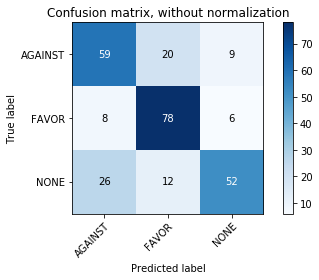

In [50]:
mallet_report = RandomForest(X_train, X_test, y_train, y_test)
print(mallet_report)

Confusion matrix, without normalization
[[42 25 21]
 [32 54  6]
 [32 12 46]]
{'SVM_cross_val_score': [0.6172284644194758, 0.6046693812113428, 0.5715621826732938, 0.5339105339105339, 0.6544267645858833], 'SVM_mean_acc': 0.596359465360106, 'SVM_std_acc': 0.08193243719267042, 'SVM_best_estimator': SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'SVM_CM': [[42, 25, 21], [32, 54, 6], [32, 12, 46]], 'SVM_F1_SCORE': 0.5291902676873298}


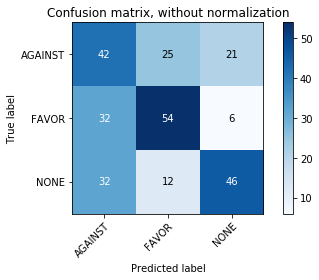

In [51]:
mallet_report = SVMClassifier(X_train, X_test, y_train, y_test)
print(mallet_report)